In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from skimage import feature 

In [2]:
# Function to load images and labels from a dataset folder
def load_dataset(dataset_path):
    images = []
    labels = []
    label_names = os.listdir(dataset_path)
    for label in label_names:
        label_path = os.path.join(dataset_path, label)
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(label)
    return images, labels

# Load dataset
dataset_path = 'Fish Disease Dataset'  # Replace with your actual dataset path
images, labels = load_dataset(dataset_path)

In [3]:
# Convert images to grayscale
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

In [4]:
# Apply LBP
from skimage.feature import local_binary_pattern

def apply_lbp(images, radius=1, n_points=8):
    lbp_images = []
    for image in images:
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        lbp_images.append(lbp)
    return lbp_images

# Apply LBP
lbp_images = apply_lbp(gray_images)

import numpy as np

def get_kirsch_kernels():
    kernels = []
    kernels.append(np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]]))
    kernels.append(np.array([[-3, 5, 5], [-3, 0, 5], [-3, -3, -3]]))
    kernels.append(np.array([[-3, -3, 5], [-3, 0, 5], [-3, -3, 5]]))
    kernels.append(np.array([[-3, -3, -3], [-3, 0, 5], [-3, 5, 5]]))
    kernels.append(np.array([[-3, -3, -3], [-3, 0, -3], [5, 5, 5]]))
    kernels.append(np.array([[-3, -3, -3], [5, 0, -3], [5, 5, -3]]))
    kernels.append(np.array([[5, -3, -3], [5, 0, -3], [5, -3, -3]]))
    kernels.append(np.array([[5, 5, -3], [5, 0, -3], [-3, -3, -3]]))
    return kernels

def apply_ldp(images):
    ldp_images = []
    kernels = get_kirsch_kernels()
    for image in images:
        magnitude = np.zeros_like(image, dtype=np.float32)
        for kernel in kernels:
            response = cv2.filter2D(image, cv2.CV_32F, kernel)
            magnitude = np.maximum(magnitude, response)
        ldp_images.append(magnitude.astype(np.uint8))
    return ldp_images

# Apply LDP
ldp_images = apply_ldp(gray_images)


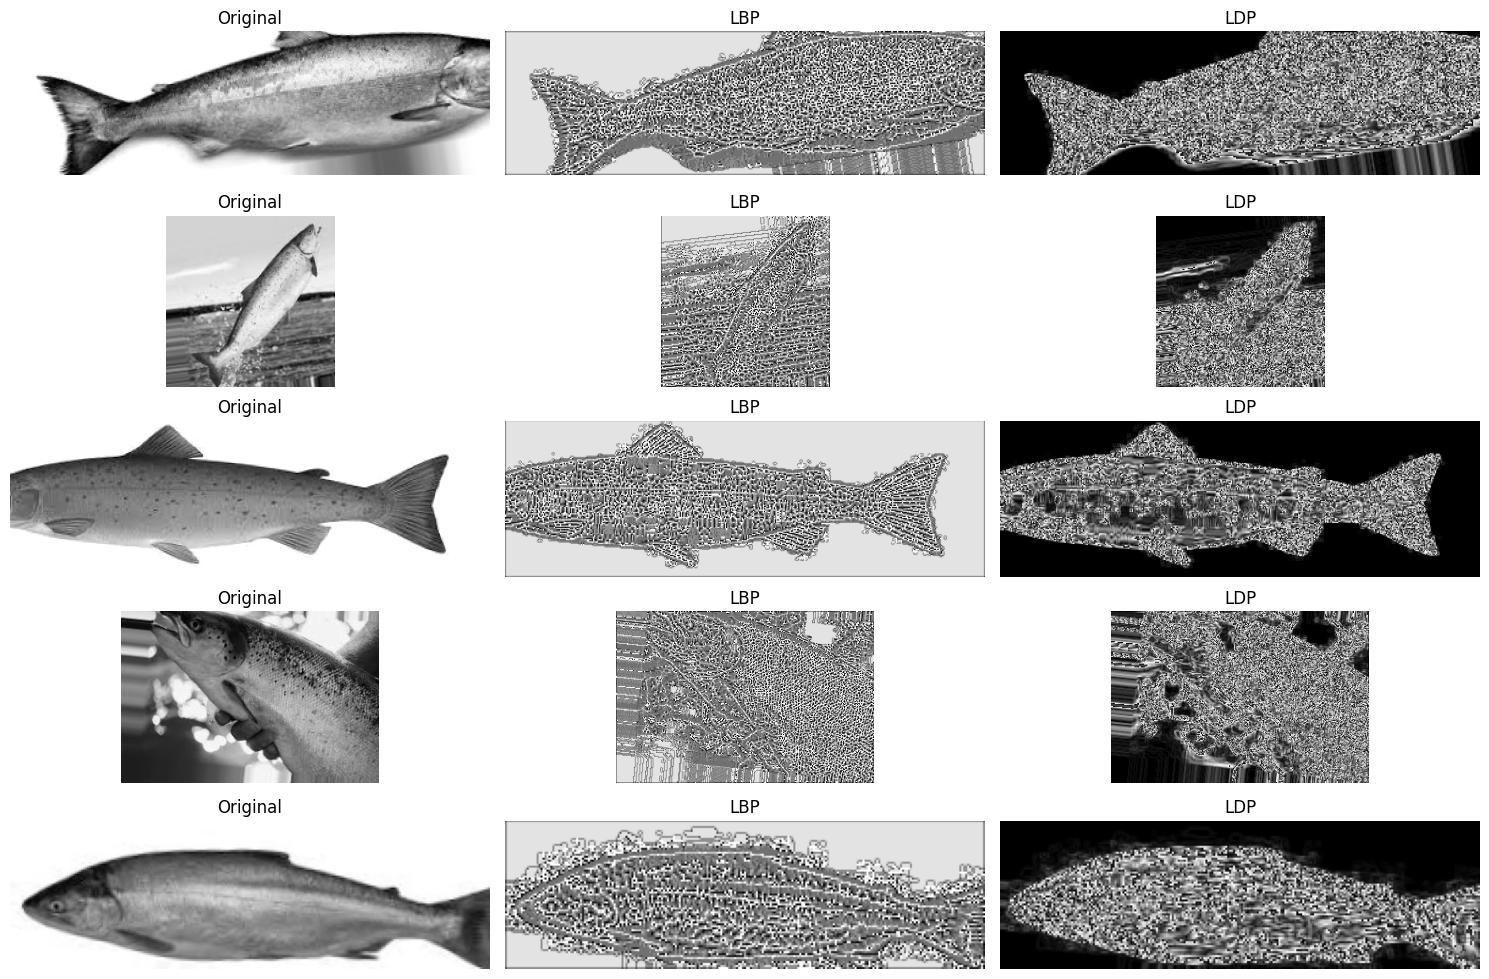

In [5]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(original, lbp, ldp, n_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(n_samples):
        # Display original grayscale image
        plt.subplot(n_samples, 3, 3 * i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Display LBP image
        plt.subplot(n_samples, 3, 3 * i + 2)
        plt.imshow(lbp[i], cmap='gray')
        plt.title('LBP')
        plt.axis('off')
        
        # Display LDP image
        plt.subplot(n_samples, 3, 3 * i + 3)
        plt.imshow(ldp[i], cmap='gray')
        plt.title('LDP')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming gray_images, lbp_images, and ldp_images are already defined
display_images(gray_images, lbp_images, ldp_images, n_samples=5)


In [6]:
# Compute histogram
def compute_histogram(image, bins=16):
    hist, _ = np.histogram(image.ravel(), bins=bins, range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist


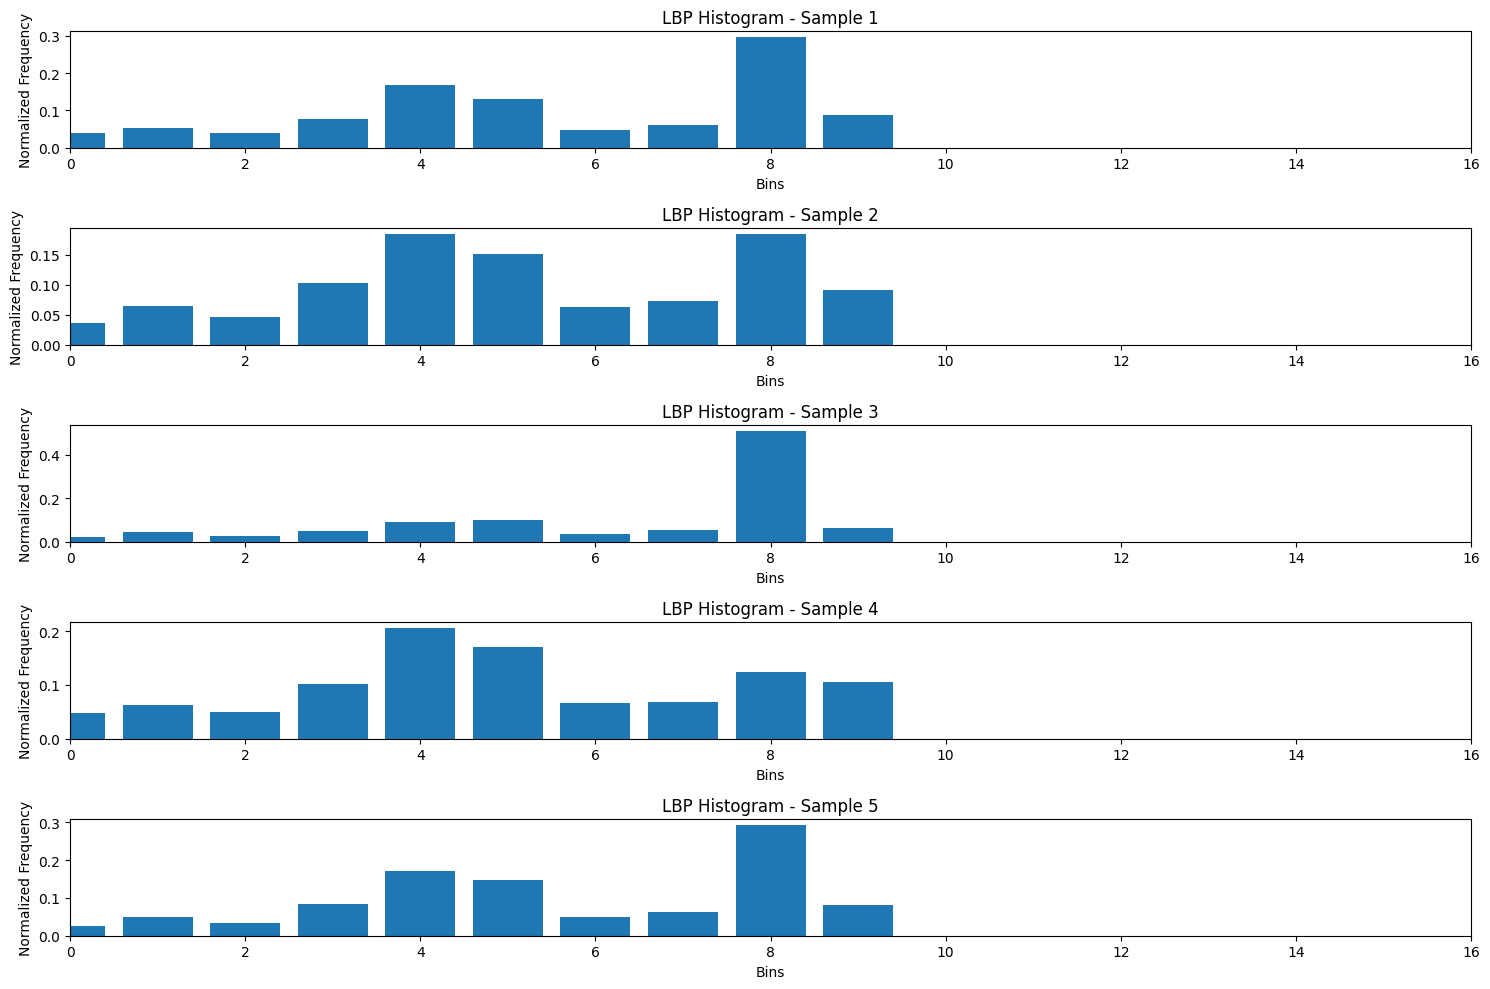

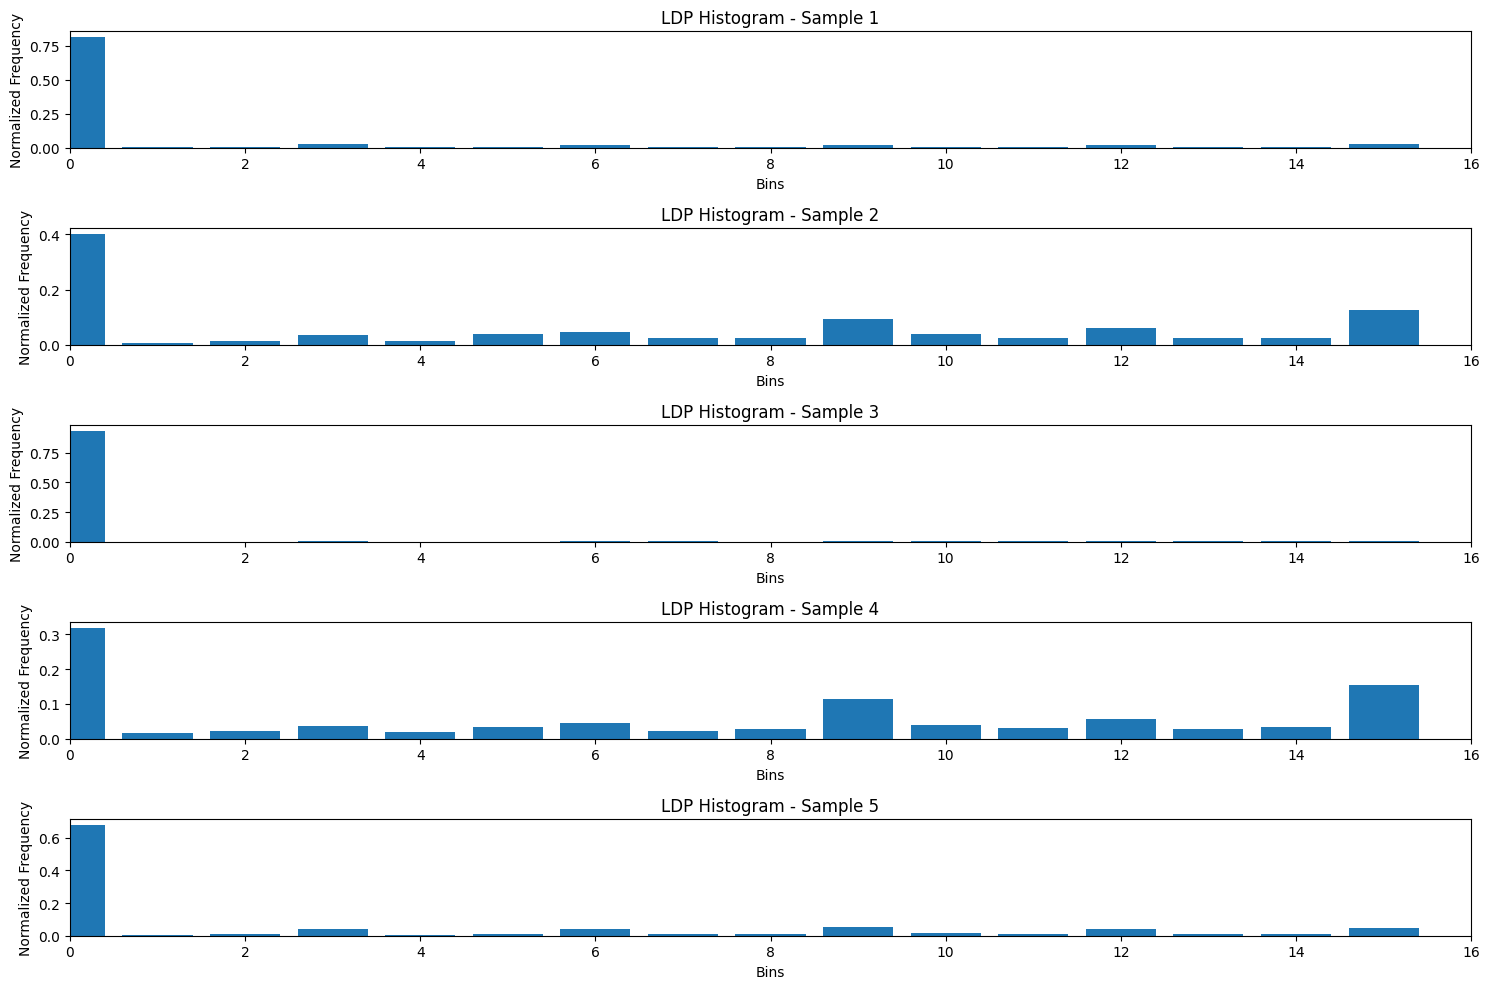

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute and display histograms
def display_histograms(images, title, n_samples=5, bins=16):
    plt.figure(figsize=(15, 10))
    
    for i in range(n_samples):
        # Compute histogram
        hist = compute_histogram(images[i], bins=bins)
        
        # Display histogram
        plt.subplot(n_samples, 1, i + 1)
        plt.bar(range(bins), hist, width=0.8)
        plt.title(f'{title} - Sample {i + 1}')
        plt.xlabel('Bins')
        plt.ylabel('Normalized Frequency')
        plt.xlim(0, bins)
    
    plt.tight_layout()
    plt.show()

# Assuming lbp_images and ldp_images are already defined
display_histograms(lbp_images, title='LBP Histogram', n_samples=5, bins=16)
display_histograms(ldp_images, title='LDP Histogram', n_samples=5, bins=16)


In [8]:
def apply_bwt(image, block_size=8):
    h, w = image.shape
    bwt_image = np.zeros_like(image)
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            mean = np.mean(block)
            std = np.std(block)
            bwt_image[i:i + block_size, j:j + block_size] = mean + std * np.sign(block - mean)
    return bwt_image

# Apply BWT
bwt_images = [apply_bwt(image) for image in gray_images]


In [9]:
def apply_hough_transform(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    hough_image = np.zeros_like(image)
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(hough_image, (x1, y1), (x2, y2), 255, 1)
    return hough_image

# Apply Hough Transform
hough_images = [apply_hough_transform(image) for image in gray_images]


In [11]:

import matplotlib.pyplot as plt

# Function to display images
def display_images(original, lbp, ldp, n_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(n_samples):
        # Display original grayscale image
        plt.subplot(n_samples, 3, 3 * i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Display LBP image
        plt.subplot(n_samples, 3, 3 * i + 2)
        plt.imshow(lbp[i], cmap='gray')
        plt.title('LBP')
        plt.axis('off')
        
        # Display LDP image
        plt.subplot(n_samples, 3, 3 * i + 3)
        plt.imshow(ldp[i], cmap='gray')
        plt.title('LDP')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming gray_images, lbp_images, and ldp_images are already defined
display_images(gray_images, lbp_images, ldp_images,bwt_images, n_samples=5)

def display_transformed_images(original, transformed1, transformed2, title1, title2, n_samples=5):
    plt.figure(figsize=(15, 10))
    
    for i in range(n_samples):
        # Display original grayscale image
        plt.subplot(n_samples, 3, 3 * i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        # Display first transformed image
        plt.subplot(n_samples, 3, 3 * i + 2)
        plt.imshow(transformed1[i], cmap='gray')
        plt.title(title1)
        plt.axis('off')
        
        # Display second transformed image
        plt.subplot(n_samples, 3, 3 * i + 3)
        plt.imshow(transformed2[i], cmap='gray')
        plt.title(title2)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Assuming bwt_images and hough_images are already defined
display_transformed_images(gray_images, bwt_images, hough_images,lbp_images, ldp_images, title1='BWT', title2='Hough Transform', n_samples=5)


TypeError: display_images() got multiple values for argument 'n_samples'

In [12]:
lbp_features_list = []
ldp_features_list = []
bwt_features_list = []
hough_features_list = []

for gray_image in gray_images:
    # Apply LBP
    lbp_image = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    lbp_hist_features = compute_histogram(lbp_image, bins=16)
    lbp_features_list.append(lbp_hist_features)
    
    # Apply LDP
    ldp_image = apply_ldp([gray_image])[0]
    ldp_hist_features = compute_histogram(ldp_image, bins=16)
    ldp_features_list.append(ldp_hist_features)
    
    # Apply BWT
    bwt_image = apply_bwt(gray_image)
    bwt_hist_features = compute_histogram(bwt_image, bins=16)
    bwt_features_list.append(bwt_hist_features)
    
    # Apply Hough Transform
    hough_image = apply_hough_transform(gray_image)
    hough_hist_features = compute_histogram(hough_image, bins=16)
    hough_features_list.append(hough_hist_features)

In [13]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from skimage.feature import local_binary_pattern
import numpy as np

# Function to compute histogram
def compute_histogram(image, bins=16):
    hist, _ = np.histogram(image.ravel(), bins=bins, range=(0, bins))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Function to train and evaluate classifiers
def train_and_evaluate_model(X_train, X_test, y_train, y_test, classifier):
    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"Classification Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

if __name__ == "__main__":
    # Assuming `gray_images`, `labels`, and feature extraction functions are defined as before
    
    # Convert labels to numerical values using LabelEncoder
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    
    # Extract LBP features
    lbp_features_list = []
    
    for gray_image in gray_images:
        # Apply LBP
        lbp_image = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
        lbp_hist_features = compute_histogram(lbp_image, bins=16)
        lbp_features_list.append(lbp_hist_features)
    
    # Convert to numpy array
    X_lbp = np.array(lbp_features_list)
    y_lbp = numerical_labels
    
    # Split data into training and testing sets for LBP features
    X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y_lbp, test_size=0.2, random_state=42)
    
    # Define classifiers to evaluate
    classifiers = [
        SVC(kernel='linear'),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        AdaBoostClassifier(n_estimators=100, random_state=42),
        DecisionTreeClassifier(random_state=42),
        LogisticRegression(),
        GaussianNB()
    ]
    
    # Iterate over classifiers
    for clf in classifiers:
        print(f"\nTraining and evaluating {clf.__class__.__name__} on LBP features...")
        train_and_evaluate_model(X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp, clf)



Training and evaluating SVC on LBP features...
Classifier: SVC
Classification Accuracy: 0.5901639344262295
Precision: 0.6029003783102144
Recall: 0.5901639344262295
F1 Score: 0.5886202957611683
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        33
           1       0.54      0.68      0.60        28

    accuracy                           0.59        61
   macro avg       0.60      0.60      0.59        61
weighted avg       0.60      0.59      0.59        61


Training and evaluating RandomForestClassifier on LBP features...
Classifier: RandomForestClassifier
Classification Accuracy: 0.9508196721311475
Precision: 0.9514379592990391
Recall: 0.9508196721311475
F1 Score: 0.9508727683015862
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.93      0.96      0.95        28

    accuracy                         

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [15]:
if __name__ == "__main__":
    # Assuming `gray_images`, `labels`, and feature extraction functions are defined as before
    
    # Convert labels to numerical values using LabelEncoder
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    
    # Extract LDP features
    ldp_features_list = []
    
    for gray_image in gray_images:
        # Apply LDP
        ldp_image = apply_ldp([gray_image])[0]
        ldp_hist_features = compute_histogram(ldp_image, bins=16)
        ldp_features_list.append(ldp_hist_features)
    
    # Convert to numpy array
    X_ldp = np.array(ldp_features_list)
    y_ldp = numerical_labels
    
    # Split data into training and testing sets for LDP features
    X_train_ldp, X_test_ldp, y_train_ldp, y_test_ldp = train_test_split(X_ldp, y_ldp, test_size=0.2, random_state=42)
    
    # Define classifiers to evaluate
    classifiers = [
        SVC(kernel='linear'),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        AdaBoostClassifier(n_estimators=100, random_state=42),
        DecisionTreeClassifier(random_state=42),
        LogisticRegression(),
        GaussianNB()
    ]
    
    # Iterate over classifiers
    for clf in classifiers:
        print(f"\nTraining and evaluating {clf.__class__.__name__} on LDP features...")
        train_and_evaluate_model(X_train_ldp, X_test_ldp, y_train_ldp, y_test_ldp, clf)



Training and evaluating SVC on LDP features...
Classifier: SVC
Classification Accuracy: 0.6721311475409836
Precision: 0.6721311475409836
Recall: 0.6721311475409836
F1 Score: 0.6721311475409836
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        33
           1       0.64      0.64      0.64        28

    accuracy                           0.67        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.67      0.67      0.67        61


Training and evaluating RandomForestClassifier on LDP features...
Classifier: RandomForestClassifier
Classification Accuracy: 0.8852459016393442
Precision: 0.8898995240613432
Recall: 0.8852459016393442
F1 Score: 0.8854311382791517
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                         

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [16]:
if __name__ == "__main__":
    # Assuming `gray_images`, `labels`, and feature extraction functions are defined as before
    
    # Convert labels to numerical values using LabelEncoder
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    
    # Extract LBP features
    lbp_features_list = []
    
    for gray_image in gray_images:
        # Apply LBP
        lbp_image = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
        lbp_hist_features = compute_histogram(lbp_image, bins=16)
        lbp_features_list.append(lbp_hist_features)
    
    # Extract LDP features
    ldp_features_list = []
    
    for gray_image in gray_images:
        # Apply LDP
        ldp_image = apply_ldp([gray_image])[0]
        ldp_hist_features = compute_histogram(ldp_image, bins=16)
        ldp_features_list.append(ldp_hist_features)
    
    # Convert to numpy arrays
    X_lbp = np.array(lbp_features_list)
    X_ldp = np.array(ldp_features_list)
    X_combined = np.concatenate((X_lbp, X_ldp), axis=1)
    y_combined = numerical_labels
    
    # Split data into training and testing sets for combined features
    X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
    
    # Define classifiers to evaluate
    classifiers = [
        SVC(kernel='linear'),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        AdaBoostClassifier(n_estimators=100, random_state=42),
        DecisionTreeClassifier(random_state=42),
        LogisticRegression(),
        GaussianNB()
    ]
    
    # Iterate over classifiers
    for clf in classifiers:
        print(f"\nTraining and evaluating {clf.__class__.__name__} on combined LBP and LDP features...")
        train_and_evaluate_model(X_train_combined, X_test_combined, y_train_combined, y_test_combined, clf)


Training and evaluating SVC on combined LBP and LDP features...
Classifier: SVC
Classification Accuracy: 0.6721311475409836
Precision: 0.6721311475409836
Recall: 0.6721311475409836
F1 Score: 0.6721311475409836
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        33
           1       0.64      0.64      0.64        28

    accuracy                           0.67        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.67      0.67      0.67        61


Training and evaluating RandomForestClassifier on combined LBP and LDP features...
Classifier: RandomForestClassifier
Classification Accuracy: 0.9672131147540983
Precision: 0.9693989071038251
Recall: 0.9672131147540983
F1 Score: 0.9672661107970605
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        33
           1       0.93      1.00      0.97        28

   

C:\Users\KIIT\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.72      0.70      0.71        33
           1       0.66      0.68      0.67        28

    accuracy                           0.69        61
   macro avg       0.69      0.69      0.69        61
weighted avg       0.69      0.69      0.69        61



In [17]:

if __name__ == "__main__":
    # Assuming `gray_images`, `labels`, and feature extraction functions are defined as before
    
    # Convert labels to numerical values using LabelEncoder
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)
    
    # Extract BWT features and construct X_bwt
    bwt_features_list = []
    
    for gray_image in gray_images:
        # Apply BWT and ensure it returns a numpy array
        bwt_features = apply_bwt(gray_image)
        
        # Check if `apply_bwt` returns a list of arrays
        if isinstance(bwt_features, list):
            # Concatenate or reshape arrays appropriately
            bwt_features_concat = np.concatenate(bwt_features, axis=1)  # Adjust axis as per your feature shape
            bwt_features_list.append(bwt_features_concat)
        else:
            # Assuming `apply_bwt` returns a single numpy array
            bwt_features_list.append(bwt_features)
    
    # Convert `bwt_features_list` to a numpy array
    X_bwt = np.array(bwt_features_list)
    y_bwt = numerical_labels
    
    # Split data into training and testing sets for BWT features
    X_train_bwt, X_test_bwt, y_train_bwt, y_test_bwt = train_test_split(X_bwt, y_bwt, test_size=0.2, random_state=42)
    
    # Define classifiers to evaluate
    classifiers = [
        SVC(kernel='linear'),
        RandomForestClassifier(n_estimators=100, random_state=42),
        GradientBoostingClassifier(n_estimators=100, random_state=42),
        AdaBoostClassifier(n_estimators=100, random_state=42),
        DecisionTreeClassifier(random_state=42),
        LogisticRegression(),
        GaussianNB()
    ]
    
    # Iterate over classifiers
    for clf in classifiers:
        print(f"\nTraining and evaluating {clf.__class__.__name__} on BWT features...")
        train_and_evaluate_model(X_train_bwt, X_test_bwt, y_train_bwt, y_test_bwt, clf)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (305,) + inhomogeneous part.